In [0]:
import pandas as pd
import numpy as np

import keras
from keras.layers import LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, Model

In [4]:
df = pd.read_csv('household_power_consumption.txt', sep=';')
print('Форма исходного файла:', df.shape)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Форма исходного файла: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
# Считаем количество пропущенных строк

no_data = df.loc[df['Global_active_power'] == '?']
print('Количество пропущенных минут:', no_data.shape[0])
no_data

Количество пропущенных минут: 25979


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...,...
1990185,28/9/2010,19:09:00,?,?,?,?,?,?,NaN
1990186,28/9/2010,19:10:00,?,?,?,?,?,?,NaN
1990187,28/9/2010,19:11:00,?,?,?,?,?,?,NaN
1990188,28/9/2010,19:12:00,?,?,?,?,?,?,NaN


In [6]:
# Отбрасываем строки без данных и все столбцы кроме даты, времени и потребления

data = df.drop(index=no_data.index)
data = data.drop(data.columns.difference(['Date', 'Time', 'Global_active_power']), axis=1)

# Обрезаем время до часов и переводим потребление в числовой тип
data['Time'] = pd.to_numeric(data.Time.str[:2])
data['Global_active_power'] = data['Global_active_power'].astype(float)
data['Date'] = data['Date'].astype(str)

data

,Date,Time,Global_active_power
0,16/12/2006,17,4.216
1,16/12/2006,17,5.360
2,16/12/2006,17,5.374
3,16/12/2006,17,5.388
4,16/12/2006,17,3.666
...,...,...,...
2075254,26/11/2010,20,0.946
2075255,26/11/2010,20,0.944
2075256,26/11/2010,21,0.938
2075257,26/11/2010,21,0.934


In [7]:
# Data resampling by hours

data = data.groupby(['Date', 'Time']).sum().reset_index()
print(data.shape)
data.head()

(34168, 3)


,Date,Time,Global_active_power
0,1/1/2007,0,153.038
1,1/1/2007,1,151.404
2,1/1/2007,2,154.940
3,1/1/2007,3,152.500
4,1/1/2007,4,148.544


In [8]:
# По скольким часам в каждом дне есть данные

number_of_hours = data.groupby(['Date']).count().rename(columns={'Time' : 'Number_of_hours'}).drop(columns='Global_active_power')
print(number_of_hours.shape)
number_of_hours.head()

(1433, 1)


,Number_of_hours
Date,
1/1/2007,24
1/1/2008,24
1/1/2009,24
1/1/2010,24
1/10/2007,24


In [9]:
# Получаем даты, в которые неизвестны данные в каждом часу

notfull = number_of_hours.loc[number_of_hours['Number_of_hours'] != 24]
print(notfull.shape)
notfull.head()

(16, 1)


,Number_of_hours
Date,
12/1/2010,15
13/6/2009,1
13/8/2009,10
14/1/2010,5
15/6/2009,17


In [10]:
# Оставляем дни, в которых нам известны данные по всем часам

data = data[~data['Date'].isin(notfull.index) ]
print(data.shape)
data.head()

(34008, 3)


,Date,Time,Global_active_power
0,1/1/2007,0,153.038
1,1/1/2007,1,151.404
2,1/1/2007,2,154.940
3,1/1/2007,3,152.500
4,1/1/2007,4,148.544


In [0]:
# Сортируем по дате и времени

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Date', 'Time'])

# Закончили обрабатывать исходные данные

In [0]:
data.to_csv('data_preprocessed.csv')

In [14]:
timesteps = 24
number_of_sequences = int(len(data) / timesteps)
print('Number of sequences of length 24:', number_of_sequences)

Number of sequences of length 24: 1417


In [15]:
# Каждая последовательность - один день

data_sequences = [data['Global_active_power'][i*timesteps : (i+1) * timesteps] for i in range(number_of_sequences)]
print('Вид последовательности:') 
data_sequences[-1]

Вид последовательности:


3639     52.860
3640     16.036
3641     21.038
3642     19.224
3643     16.752
3644     17.376
3645     39.382
3646    161.640
3647    142.554
3648     93.328
3649    111.866
3650     84.704
3651     86.096
3652     48.110
3653     79.256
3654    107.446
3655     81.700
3656    147.366
3657    136.852
3658    143.518
3659    105.200
3660     66.894
3661     19.232
3662     38.392
Name: Global_active_power, dtype: float64

In [0]:
X = np.array(data_sequences[:-1])
Y = np.array(data_sequences[1:])
X = X.reshape((X.shape[0], X.shape[1], 1, 1))
Y = Y.reshape((Y.shape[0], Y.shape[1], 1, 1))

In [0]:
prop_train = 0.8
ntrain = int(X.shape[0]*prop_train)

X_train, X_val = X[:ntrain], X[ntrain:]
Y_train, Y_val = Y[:ntrain], Y[ntrain:]

In [74]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers
from keras import models
from keras.layers.normalization import BatchNormalization
# ----------------------------------------------------------
# EDITABLE PARAMETERS
# Read the documentation in the script head for more details
# ----------------------------------------------------------

# length of input
input_len = 1000

# The window length of the moving average used to generate
# the output from the input in the input/output pair used
# to train the LSTM
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 2

# The input sequence length that the LSTM is trained on for each output point
lahead = 1

# training parameters passed to "model.fit(...)"
batch_size = 100
epochs = 300

# ------------
# MAIN PROGRAM
# ------------


def create_model(stateful):
    in_out_neurons = 24
    
    inp = layers.Input(batch_shape= (batch_size, 1, 24, 1),
                       name="input")  
    conv1 = TimeDistributed(Conv1D(filters=200, kernel_size=13))(inp);
    b1 = BatchNormalization()(conv1);
    pool1d = TimeDistributed(MaxPooling1D(pool_size=3))(b1)
    flat = TimeDistributed(Flatten())(pool1d)
    b2 = BatchNormalization()(flat);
    rnn = layers.LSTM(64, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(b2)
    b3 = BatchNormalization()(rnn);

    dens = layers.Dense(in_out_neurons,name="dense")(b3)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  optimizer="adam")
    return model

print('Creating Stateful Model...')
model_stateful = create_model(stateful=True)
model_stateful.summary()

#(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
X_train = X_train.reshape(X_train.shape[0], 1, 24,1)
Y_train = Y_train.reshape(Y_train.shape[0], 1, 24)

X_val = X_val.reshape(X_val.shape[0], 1, 24,1)
Y_val = Y_val.reshape(Y_val.shape[0], 1, 24)
print('x_train.shape: ', X_train.shape)
print('y_train.shape: ', Y_train.shape)
print('x_test.shape: ', X_val.shape)
print('y_test.shape: ', Y_val.shape)




Creating Stateful Model...
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (100, 1, 24, 1)           0         
_________________________________________________________________
time_distributed_59 (TimeDis (100, 1, 12, 200)         2800      
_________________________________________________________________
batch_normalization_57 (Batc (100, 1, 12, 200)         800       
_________________________________________________________________
time_distributed_60 (TimeDis (100, 1, 4, 200)          0         
_________________________________________________________________
time_distributed_61 (TimeDis (100, 1, 800)             0         
_________________________________________________________________
batch_normalization_58 (Batc (100, 1, 800)             3200      
_________________________________________________________________
RNN (LSTM)                   (1

In [75]:
print('Training')
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    model_stateful.fit(X_train[:1100],
                       Y_train[:1100],
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(X_val[:200], Y_val[:200]),
                       shuffle=False)
    model_stateful.reset_states()


Training
Epoch 1 / 300
Train on 1100 samples, validate on 200 samples
Epoch 1/1
1100/1100 [==============================] - 1s 991us/step - loss: 7416.8074 - val_loss: 5746.4636
Epoch 2 / 300
Train on 1100 samples, validate on 200 samples
Epoch 1/1
1100/1100 [==============================] - 0s 194us/step - loss: 7387.9161 - val_loss: 5716.8115
Epoch 3 / 300
Train on 1100 samples, validate on 200 samples
Epoch 1/1
1100/1100 [==============================] - 0s 193us/step - loss: 7366.1339 - val_loss: 5683.4387
Epoch 4 / 300
Train on 1100 samples, validate on 200 samples
Epoch 1/1
1100/1100 [==============================] - 0s 180us/step - loss: 7341.9695 - val_loss: 5662.5627
Epoch 5 / 300
Train on 1100 samples, validate on 200 samples
Epoch 1/1
1100/1100 [==============================] - 0s 190us/step - loss: 7313.8091 - val_loss: 5646.1099
Epoch 6 / 300
Train on 1100 samples, validate on 200 samples
Epoch 1/1
1100/1100 [==============================] - 0s 189us/step - loss: 728

In [76]:
print('Predicting')
predicted_stateful = model_stateful.predict(X_val[:200], batch_size=batch_size)

Predicting


# **Предсказание результатов**

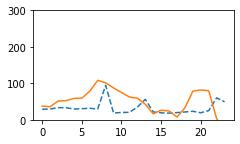

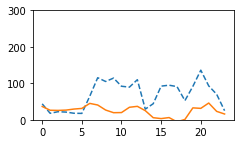

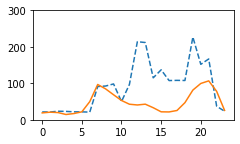

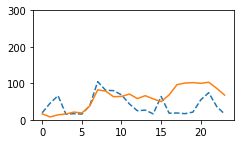

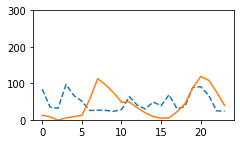

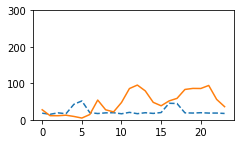

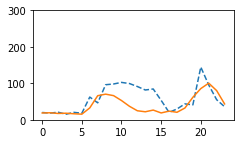

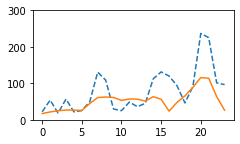

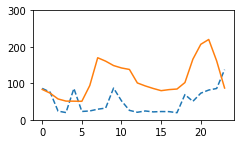

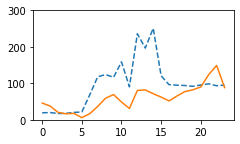

In [77]:
for i in range(10):
  fig = plt.figure(figsize=(16,10))
  fig.subplots_adjust(hspace = 0.32,wspace = 0.15)
  ax = fig.add_subplot(4,4,1)
  ax.set_ylim(0, 300)
  ax.plot(Y_val[i].reshape(24),"--",label="expected")
  ax.plot(predicted_stateful[i].reshape(24) ,label="predicted")